In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
data = pd.read_csv("../PMD_Analysis/data/pmd_full_4.txt",sep = "\t", header=None)

In [3]:
data.columns = ['encrypted_customer_id','is_promo','is_pmd','revenue','units','min_date','max_date']


data['min_date'] = pd.to_datetime(data['min_date'])
data['max_date'] = pd.to_datetime(data['max_date'])

In [4]:
data.shape

(4873194, 7)

In [5]:
print(data.shape)
print(data['encrypted_customer_id'].nunique())
data.head()

(4873194, 7)
2113141


,encrypted_customer_id,is_promo,is_pmd,revenue,units,min_date,max_date
0,A29NFF34BNM6WI,non_promo,non_pmd,49.01,11,2016-12-23,2019-05-20
1,A2XOOG7N9LBM2D,non_promo,non_pmd,289.94,72,2015-08-18,2019-07-06
2,A37HBT237VVUN7,non_promo,non_pmd,3358.30,343,2014-12-06,2019-05-30
3,APLRQYYT84YUL,promo,non_pmd,8.31,2,2018-11-26,2019-02-24
4,A1R8G0LEHUYM9,non_promo,non_pmd,1926.09,474,2015-03-14,2019-07-06


# Part One - how many customers have only pmd

In [6]:
table = pd.pivot_table(data, values='units', index=['encrypted_customer_id'],
                       columns=['is_pmd'], aggfunc=np.sum, fill_value=0).reset_index()

In [7]:
table.head()

is_pmd,encrypted_customer_id,is_pmd,non_pmd
0,A0000366A0GK5998YBDT,1,71
1,A0000666DG4NFCAMI8,5,30
2,A0001210LXBR1BZ5BP3,13,19
3,A00014502OC4OBEX6TX4A,1,1
4,A0002142161IPUDSA8D6H,4,27


In [8]:
table[table['non_pmd'] == 0].shape[0] / table['encrypted_customer_id'].nunique()

0.037025451685429416

In [9]:
table[table['non_pmd'] == 0].tail()

is_pmd,encrypted_customer_id,is_pmd,non_pmd
2113077,AZZV50VYBWJ11,5,0
2113104,AZZX1XYC5954A,1,0
2113124,AZZYC5ZA1SQUR,3,0
2113127,AZZYO1YQ1HWI5,1,0
2113136,AZZZRNKD8SDUD,2,0


In [10]:
data[data['encrypted_customer_id'] == 'A0000666DG4NFCAMI8']

,encrypted_customer_id,is_promo,is_pmd,revenue,units,min_date,max_date
86995,A0000666DG4NFCAMI8,non_promo,non_pmd,110.65,27,2016-01-24,2019-06-01
2634146,A0000666DG4NFCAMI8,promo,is_pmd,15.91,5,2017-05-26,2018-11-23
3714286,A0000666DG4NFCAMI8,promo,non_pmd,12.57,3,2018-12-18,2018-12-23


# Part Two - sampled 

In [11]:
df = pd.read_csv("../PMD_Analysis/data/sampled_4.txt", sep = "\t", header=None)

In [12]:
df.columns = ['encrypted_customer_id','is_promo','is_pmd','fufill_date_local',
              'revenue','units','min_date','max_date']

df.head()

,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date
0,A27RK0PZTWCCOU,promo,is_pmd,2019-04-30 00:00:00,3.32,1,2019-04-30 00:00:00,2019-04-30 00:00:00
1,AX1QMYZ9ZMFPR,non_promo,non_pmd,2019-03-09 00:00:00,3.35,1,2019-03-09 00:00:00,2019-03-09 00:00:00
2,A16JZ6X4GEGEK5,promo,is_pmd,2018-06-10 00:00:00,4.19,1,2018-06-10 00:00:00,2018-06-10 00:00:00
3,A3KD1FVDAXM3H1,promo,is_pmd,2018-07-11 00:00:00,5.03,1,2018-07-11 00:00:00,2018-07-11 00:00:00
4,A3HGBF6P6CNA1U,non_promo,non_pmd,2017-07-24 00:00:00,10.08,1,2017-07-24 00:00:00,2017-07-24 00:00:00


In [13]:
#Create function to create first PMD event per customer

def first_pmd_event(df):
    
    df['fufill_date_local'] = pd.to_datetime(df['fufill_date_local'])
    df['min_date'] = pd.to_datetime(df['min_date'])
    df['max_date'] = pd.to_datetime(df['max_date'])
    
    first_pmd = df[df['is_pmd'] == 'is_pmd'].groupby("encrypted_customer_id")['fufill_date_local'].min().reset_index()
    
    
    df_new = pd.merge(left = df, right = first_pmd, left_on = ['encrypted_customer_id'],
                     right_on = ['encrypted_customer_id'], how = 'left')
    
    df_new.columns = ['encrypted_customer_id','is_promo','is_pmd','fufill_date_local',
              'revenue','units','min_date','max_date','first_pmd_date']
    
    first_ever = df.groupby('encrypted_customer_id')['fufill_date_local'].min().reset_index()
    first_ever.columns = ['encrypted_customer_id','first_ever_purchase_date']
    
    df_new = pd.merge(left = df_new, right = first_ever, left_on = ['encrypted_customer_id'],
                     right_on = ['encrypted_customer_id'], how = 'left')
    
    
    return df_new

In [14]:
df_new = first_pmd_event(df)

In [15]:
df_new.head()

,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date
0,A27RK0PZTWCCOU,promo,is_pmd,2019-04-30,3.32,1,2019-04-30,2019-04-30,2019-04-26,2019-04-13
1,AX1QMYZ9ZMFPR,non_promo,non_pmd,2019-03-09,3.35,1,2019-03-09,2019-03-09,2016-11-04,2014-04-30
2,A16JZ6X4GEGEK5,promo,is_pmd,2018-06-10,4.19,1,2018-06-10,2018-06-10,2015-09-25,2015-07-29
3,A3KD1FVDAXM3H1,promo,is_pmd,2018-07-11,5.03,1,2018-07-11,2018-07-11,2018-07-11,2018-03-02
4,A3HGBF6P6CNA1U,non_promo,non_pmd,2017-07-24,10.08,1,2017-07-24,2017-07-24,2017-04-03,2016-04-29


In [16]:
df_new[(df_new['encrypted_customer_id']== 'AX1QMYZ9ZMFPR') & (df_new['is_pmd'] == 'is_pmd')]

,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date
477867,AX1QMYZ9ZMFPR,promo,is_pmd,2018-07-17,1.67,1,2018-07-17,2018-07-17,2016-11-04,2014-04-30
537184,AX1QMYZ9ZMFPR,promo,is_pmd,2019-05-05,0.83,1,2019-05-05,2019-05-05,2016-11-04,2014-04-30
843946,AX1QMYZ9ZMFPR,promo,is_pmd,2016-11-04,0.83,1,2016-11-04,2016-11-04,2016-11-04,2014-04-30


In [17]:
table_pivot = pd.pivot_table(df_new, values='units', index=['encrypted_customer_id'],
                       columns=['is_pmd'], aggfunc=np.sum, fill_value=0).reset_index()

In [18]:
table_pivot[table_pivot['non_pmd'] == 0].shape[0] /  df_new['encrypted_customer_id'].nunique()

0.0371

# Part Three - customers who purchased both

In [19]:
df_new[(df_new['encrypted_customer_id'].isin(['A00227261SMGG33C7MOOY']))].sort_values(by = 'fufill_date_local', ascending = True).head()

,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date
2823884,A00227261SMGG33C7MOOY,non_promo,non_pmd,2014-09-24,8.40,1,2014-09-24,2014-09-24,2018-01-08,2014-09-24
641105,A00227261SMGG33C7MOOY,non_promo,non_pmd,2014-10-04,3.35,1,2014-10-04,2014-10-04,2018-01-08,2014-09-24
3011282,A00227261SMGG33C7MOOY,non_promo,non_pmd,2014-10-05,10.08,1,2014-10-05,2014-10-05,2018-01-08,2014-09-24
1498605,A00227261SMGG33C7MOOY,non_promo,non_pmd,2014-11-09,5.87,1,2014-11-09,2014-11-09,2018-01-08,2014-09-24
1099323,A00227261SMGG33C7MOOY,non_promo,non_pmd,2014-11-16,8.40,1,2014-11-16,2014-11-16,2018-01-08,2014-09-24


## Distribute frequency and units before and after first PMD

In [48]:
def split_before_after_first_PMD(df):
    
    metrics_before_first_PMD_by_Promo = df[df['fufill_date_local'] < df['first_pmd_date']].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['units','revenue'].sum().reset_index()
    first_ever_purchase_by_Promo =      df[df['fufill_date_local'] < df['first_pmd_date']].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].min().reset_index()
    first_ever_purchase =               df[df['fufill_date_local'] < df['first_pmd_date']].groupby(["encrypted_customer_id"])['fufill_date_local'].min().reset_index()
    last_before_purchase =     df[df['fufill_date_local'] < df['first_pmd_date']].groupby(["encrypted_customer_id"])['fufill_date_local'].max().reset_index()
    last_beforePMD_purchase_by_Promo = df[df['fufill_date_local'] < df['first_pmd_date']].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].max().reset_index()

    df1 = pd.merge(left=metrics_before_first_PMD_by_Promo, right=first_ever_purchase_by_Promo,
                   left_on=["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    df2 = pd.merge(left=df1, right=last_beforePMD_purchase_by_Promo,
                   left_on=["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    df3 = pd.merge(left=df2, right=first_ever_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    df4 = pd.merge(left=df3, right=last_before_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df4.columns = ['encrypted_customer_id','is_promo','is_pmd','units','revenue',
                   'first_date_byPromo','last_date_byPromo','first_everdate','last_ever_date']
    
    df4['frequency_days_byPromo'] = (( df4['last_date_byPromo'] - df4['first_date_byPromo'] )
                                / np.timedelta64(1,"D") ) / (df4['units'] - 1)
    
   
    
    metrics_before_first_PMD = df[df['fufill_date_local'] <
                                      df['first_pmd_date']].groupby(["encrypted_customer_id"])['units','revenue'].sum().reset_index()
    
    
    df5 = pd.merge(left=df4, right=metrics_before_first_PMD,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    df5.columns = ['encrypted_customer_id','is_promo','is_pmd','units_byPromo','revenue_byPromo',
                   'first_date_byPromo','last_date_byPromo','first_ever_date','last_ever_date',
                   'frequency_days_byPromo','units_ever','revenue_ever']
    
    df5['frequency_days_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] )
                                / np.timedelta64(1,"D") ) / (df5['units_ever'] - 1)
    df5 = df5.fillna(0)
    
   
                 
    df5['label'] = np.select(
        [
                    df5['units_ever'] <  metrics_before_first_PMD['units'].quantile(0.25),
        
                    (df5['units_ever'] >= metrics_before_first_PMD['units'].quantile(0.25)  ) & 
                    (df5['units_ever'] <  metrics_before_first_PMD['units'].quantile(0.50)  ),
        
                    (df5['units_ever'] >=  metrics_before_first_PMD['units'].quantile(0.5)  ) &
                    (df5['units_ever'] <  metrics_before_first_PMD['units'].quantile(0.75) ),
                    
                    df5['units_ever'] >=  metrics_before_first_PMD['units'].quantile(0.75) 
        ],
        [
            'A_Below_25',
            'B_Between_25_50',
            'C_Between_50_75',
            'D_Above_75'
        ],
        default = 'E_Unknown'

    )
    
    df5['ARPU_total'] = df5['revenue_ever'] / df5['units_ever'] 
    df5['share_as_total'] = df5['units_byPromo'] / df5['units_ever']
    
    df5['timeframe_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] ) / np.timedelta64(1,"M") ) 
    df5['timeframe_general_by_Promo'] = (( df5['last_date_byPromo'] - df5['first_date_byPromo'] ) / np.timedelta64(1,"M") ) 
    
    
    return df5
    

In [49]:
before = split_before_after_first_PMD(df_new)

In [50]:
before[before['encrypted_customer_id'].isin(['A00227261SMGG33C7MOOY','AX1QMYZ9ZMFPR'])]

,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,label,ARPU_total,share_as_total,timeframe_general,timeframe_general_by_Promo
0,A00227261SMGG33C7MOOY,non_promo,non_pmd,29,209.42,2014-09-24,2017-12-20,2014-09-24,2017-12-20,42.250000,30,214.45,40.793103,D_Above_75,7.148333,0.966667,38.867328,38.867328
1,A00227261SMGG33C7MOOY,promo,non_pmd,1,5.03,2017-11-02,2017-11-02,2014-09-24,2017-12-20,0.000000,30,214.45,40.793103,D_Above_75,7.148333,0.033333,38.867328,0.000000
89332,AX1QMYZ9ZMFPR,non_promo,non_pmd,50,272.59,2014-04-30,2016-10-28,2014-04-30,2016-10-28,18.612245,50,272.59,18.612245,D_Above_75,5.451800,1.000000,29.963654,29.963654


In [51]:
def split_after_first_PMD(df):
    
    made_before = split_before_after_first_PMD(df)
    
    #Subset those who had non pmd as first ever transaction
    subset = df[df['encrypted_customer_id'].isin(made_before['encrypted_customer_id'])]
    
    
    metrics_after_first_PMD_by_Promo = subset[subset['fufill_date_local'] >= subset['first_pmd_date']].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['units','revenue'].sum().reset_index()
    first_afterPMD_purchase_by_Promo = subset[subset['fufill_date_local'] >= subset['first_pmd_date']].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].min().reset_index()
    first_afterPMD_ever_purchase =     subset[subset['fufill_date_local'] >= subset['first_pmd_date']].groupby(["encrypted_customer_id"])['fufill_date_local'].min().reset_index()
    
    last_afterPMD_purchase = subset[subset['fufill_date_local'] >= subset['first_pmd_date']].groupby(["encrypted_customer_id"])['fufill_date_local'].max().reset_index()
    last_afterPMD_purchase_by_Promo = subset[subset['fufill_date_local'] >= subset['first_pmd_date']].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].max().reset_index()
    
    df1 = pd.merge(left=metrics_after_first_PMD_by_Promo, right=first_afterPMD_purchase_by_Promo,
                   left_on=["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    
    df2 = pd.merge(left=df1, right=last_afterPMD_purchase_by_Promo,
                   left_on=["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    
    df3 = pd.merge(left=df2, right=first_afterPMD_ever_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    df4 = pd.merge(left=df3, right=last_afterPMD_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df4.columns = ['encrypted_customer_id','is_promo','is_pmd','units','revenue',
                   'first_date_byPromo','last_date_byPromo','first_afterPMD_everdate','last_afterPMD_ever_date']
    
    df4['frequency_days_byPromo'] = (( df4['last_date_byPromo'] - df4['first_date_byPromo'] )
                                / np.timedelta64(1,"D") ) / (df4['units'] - 1)
    
    metrics_after_first_PMD = subset[subset['fufill_date_local'] >=
                                      subset['first_pmd_date']].groupby(["encrypted_customer_id"])['units','revenue'].sum().reset_index()
    
    df5 = pd.merge(left=df4, right=metrics_after_first_PMD,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df5.columns = ['encrypted_customer_id','is_promo','is_pmd','units_byPromo','revenue_byPromo',
                   'first_date_byPromo','last_date_byPromo','first_ever_date','last_ever_date',
                   'frequency_days_byPromo','units_ever','revenue_ever']
    
    df5['frequency_days_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] )
                                / np.timedelta64(1,"D") ) / (df5['units_ever'] - 1)
    df5 = df5.fillna(0)
    
    df5['ARPU_total'] = df5['revenue_ever'] / df5['units_ever']
    
    df5['share_as_total'] = df5['units_byPromo'] / df5['units_ever']
    
    df5['timeframe_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] ) / np.timedelta64(1,"M") ) 
    df5['timeframe_general_by_Promo'] = (( df5['last_date_byPromo'] - df5['first_date_byPromo'] ) / np.timedelta64(1,"M") ) 
    
    return df5

In [52]:
after = split_after_first_PMD(df_new)

In [53]:
after[after['encrypted_customer_id'].isin(['A00227261SMGG33C7MOOY','AX1QMYZ9ZMFPR'])]

,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,ARPU_total,share_as_total,timeframe_general,timeframe_general_by_Promo
0,A00227261SMGG33C7MOOY,non_promo,non_pmd,29,138.38,2018-02-19,2019-06-21,2018-01-08,2019-06-21,17.392857,49,230.55,11.020833,4.705102,0.591837,17.380234,16.000329
1,A00227261SMGG33C7MOOY,promo,is_pmd,17,73.72,2018-01-08,2019-03-09,2018-01-08,2019-06-21,26.562500,49,230.55,11.020833,4.705102,0.346939,17.380234,13.963326
2,A00227261SMGG33C7MOOY,promo,non_pmd,3,18.45,2018-08-02,2019-05-04,2018-01-08,2019-06-21,137.500000,49,230.55,11.020833,4.705102,0.061224,17.380234,9.035093
182464,AX1QMYZ9ZMFPR,non_promo,non_pmd,74,371.09,2016-11-04,2019-07-05,2016-11-04,2019-07-05,13.328767,78,377.77,12.636364,4.843205,0.948718,31.967802,31.967802
182465,AX1QMYZ9ZMFPR,promo,is_pmd,3,3.33,2016-11-04,2019-05-05,2016-11-04,2019-07-05,456.000000,78,377.77,12.636364,4.843205,0.038462,31.967802,29.963654
182466,AX1QMYZ9ZMFPR,promo,non_pmd,1,3.35,2017-08-03,2017-08-03,2016-11-04,2019-07-05,0.000000,78,377.77,12.636364,4.843205,0.012821,31.967802,0.000000


## Change in frequency of purchasing OVERALL

In [26]:
before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].mean()

58.593384571222565

In [27]:
before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].quantile([0.25,0.5,0.75])

0.25     9.444444
0.50    27.666667
0.75    66.000000
Name: frequency_days_general, dtype: float64

In [28]:
after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].mean()

35.844227713895584

In [29]:
after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].quantile([0.25,0.5,0.75])

0.25    10.189292
0.50    20.500000
0.75    40.940972
Name: frequency_days_general, dtype: float64

### Visualization

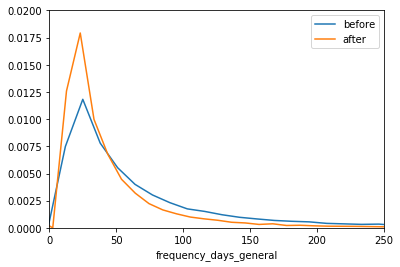

In [30]:
plt.xlim(0, 250)
plt.ylim(0, 0.02)
sns.distplot(before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = False, label = 'before')
sns.distplot(after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = False, label = 'after')
plt.show()

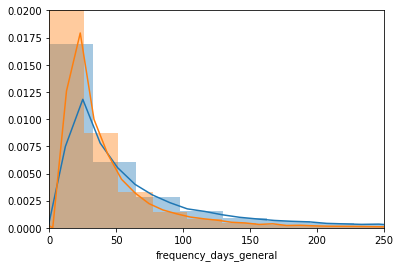

In [31]:
plt.xlim(0, 250)
plt.ylim(0, 0.02)
sns.distplot(before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = True, label = 'before')
sns.distplot(after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = True, label = 'after')
plt.show()

## Change in frequency of purchasing by Bucket Before and After PMD

In [55]:
labels = before[['encrypted_customer_id','label']]
labels = labels.drop_duplicates()

In [56]:
after_labels = pd.merge(left=after, right=labels,
                        left_on=['encrypted_customer_id'], right_on = ['encrypted_customer_id'], how = 'left')

In [57]:
after_labels.head()

,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,ARPU_total,share_as_total,timeframe_general,timeframe_general_by_Promo,label
0,A00227261SMGG33C7MOOY,non_promo,non_pmd,29,138.38,2018-02-19,2019-06-21,2018-01-08,2019-06-21,17.392857,49,230.55,11.020833,4.705102,0.591837,17.380234,16.000329,D_Above_75
1,A00227261SMGG33C7MOOY,promo,is_pmd,17,73.72,2018-01-08,2019-03-09,2018-01-08,2019-06-21,26.562500,49,230.55,11.020833,4.705102,0.346939,17.380234,13.963326,D_Above_75
2,A00227261SMGG33C7MOOY,promo,non_pmd,3,18.45,2018-08-02,2019-05-04,2018-01-08,2019-06-21,137.500000,49,230.55,11.020833,4.705102,0.061224,17.380234,9.035093,D_Above_75
3,A003960233B7I9ERAOVU6,non_promo,non_pmd,28,147.59,2018-07-21,2019-06-22,2018-05-13,2019-06-22,12.444444,30,152.61,13.965517,5.087000,0.933333,13.306228,11.039241,C_Between_50_75
4,A003960233B7I9ERAOVU6,promo,is_pmd,2,5.02,2018-05-13,2018-07-15,2018-05-13,2019-06-22,63.000000,30,152.61,13.965517,5.087000,0.066667,13.306228,2.069858,C_Between_50_75


In [58]:
before.groupby(['label'])['frequency_days_general'].mean().reset_index()

,label,frequency_days_general
0,A_Below_25,65.589609
1,B_Between_25_50,98.132818
2,C_Between_50_75,52.782564
3,D_Above_75,21.180467


In [59]:
after_labels.groupby(['label'])['frequency_days_general'].mean().reset_index()

,label,frequency_days_general
0,A_Below_25,50.689437
1,B_Between_25_50,41.056922
2,C_Between_50_75,31.442200
3,D_Above_75,19.018851


In [60]:
before['units_ever'].quantile([0.25,0.50,0.75])

0.25     3.0
0.50     8.0
0.75    20.0
Name: units_ever, dtype: float64

### Change in shares of promo / non promo purchases by Bucket by Promo

In [61]:
b = before.groupby(['is_promo','is_pmd','label'])['units_byPromo'].sum().reset_index()
b = pd.merge(left=b,right=b.groupby(['label'])['units_byPromo'].sum().reset_index(),
            left_on = ['label'], right_on = ['label'], how = 'left')
b['share'] = b['units_byPromo_x'] / b['units_byPromo_y']
b

,is_promo,is_pmd,label,units_byPromo_x,units_byPromo_y,share
0,non_promo,non_pmd,A_Below_25,24966,25538,0.977602
1,non_promo,non_pmd,B_Between_25_50,85116,86799,0.980610
2,non_promo,non_pmd,C_Between_50_75,261812,265736,0.985233
3,non_promo,non_pmd,D_Above_75,1021004,1026358,0.994783
4,promo,non_pmd,A_Below_25,572,25538,0.022398
5,promo,non_pmd,B_Between_25_50,1683,86799,0.019390
6,promo,non_pmd,C_Between_50_75,3924,265736,0.014767
7,promo,non_pmd,D_Above_75,5354,1026358,0.005217


In [39]:
a = after_labels.groupby(['is_promo','is_pmd','label'])['units_byPromo'].sum().reset_index()
a = pd.merge(left=a,right=a.groupby(['label'])['units_byPromo'].sum().reset_index(),
            left_on = ['label'], right_on = ['label'], how = 'left')
a['share'] = a['units_byPromo_x'] / a['units_byPromo_y']
a

,is_promo,is_pmd,label,units_byPromo_x,units_byPromo_y,share
0,non_promo,non_pmd,A_Below_25,211233,346817,0.609062
1,non_promo,non_pmd,B_Between_25_50,319602,487005,0.656260
2,non_promo,non_pmd,C_Between_50_75,546781,761121,0.718389
3,non_promo,non_pmd,D_Above_75,1100046,1363492,0.806786
4,promo,is_pmd,A_Below_25,127443,346817,0.367465
5,promo,is_pmd,B_Between_25_50,155395,487005,0.319083
6,promo,is_pmd,C_Between_50_75,195322,761121,0.256624
7,promo,is_pmd,D_Above_75,230757,1363492,0.169240
8,promo,non_pmd,A_Below_25,8141,346817,0.023473
9,promo,non_pmd,B_Between_25_50,12008,487005,0.024657


### Change in frequency of purchasing by Bucket Before and After PMD by Promo

In [62]:
before.groupby(['is_promo','is_pmd','label'])['frequency_days_byPromo'].mean().reset_index()

,is_promo,is_pmd,label,frequency_days_byPromo
0,non_promo,non_pmd,A_Below_25,62.763413
1,non_promo,non_pmd,B_Between_25_50,100.287026
2,non_promo,non_pmd,C_Between_50_75,53.913158
3,non_promo,non_pmd,D_Above_75,21.269762
4,promo,non_pmd,A_Below_25,0.506329
5,promo,non_pmd,B_Between_25_50,7.531264
6,promo,non_pmd,C_Between_50_75,12.702237
7,promo,non_pmd,D_Above_75,25.009658


In [41]:
after_labels.groupby(['is_promo','is_pmd','label'])['frequency_days_byPromo'].mean().reset_index()

,is_promo,is_pmd,label,frequency_days_byPromo
0,non_promo,non_pmd,A_Below_25,54.687920
1,non_promo,non_pmd,B_Between_25_50,48.781078
2,non_promo,non_pmd,C_Between_50_75,39.916575
3,non_promo,non_pmd,D_Above_75,24.733218
4,promo,is_pmd,A_Below_25,92.708129
5,promo,is_pmd,B_Between_25_50,95.961239
6,promo,is_pmd,C_Between_50_75,102.073390
7,promo,is_pmd,D_Above_75,103.643620
8,promo,non_pmd,A_Below_25,52.360572
9,promo,non_pmd,B_Between_25_50,61.909003


### Change in ARPU by Bucket Before and After PMD by Promo

In [63]:
before.groupby(['is_promo','is_pmd','label'])['ARPU_total'].mean().reset_index()

,is_promo,is_pmd,label,ARPU_total
0,non_promo,non_pmd,A_Below_25,4.726797
1,non_promo,non_pmd,B_Between_25_50,4.716446
2,non_promo,non_pmd,C_Between_50_75,4.806296
3,non_promo,non_pmd,D_Above_75,4.751482
4,promo,non_pmd,A_Below_25,6.151727
5,promo,non_pmd,B_Between_25_50,5.632200
6,promo,non_pmd,C_Between_50_75,5.452406
7,promo,non_pmd,D_Above_75,5.117717


In [64]:
after_labels.groupby(['is_promo','is_pmd','label'])['ARPU_total'].mean().reset_index()

,is_promo,is_pmd,label,ARPU_total
0,non_promo,non_pmd,A_Below_25,3.655235
1,non_promo,non_pmd,B_Between_25_50,3.900901
2,non_promo,non_pmd,C_Between_50_75,4.236522
3,non_promo,non_pmd,D_Above_75,4.754297
4,promo,is_pmd,A_Below_25,3.276201
5,promo,is_pmd,B_Between_25_50,3.644043
6,promo,is_pmd,C_Between_50_75,4.089552
7,promo,is_pmd,D_Above_75,4.700911
8,promo,non_pmd,A_Below_25,4.542902
9,promo,non_pmd,B_Between_25_50,4.723391


### Change in total ARPU by Bucket Before and After PMD by Promo

In [111]:
before.head()

,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,label,ARPU_total,share_as_total,timeframe_general,timeframe_general_by_Promo
0,A00227261SMGG33C7MOOY,non_promo,non_pmd,29,209.42,2014-09-24,2017-12-20,2014-09-24,2017-12-20,42.25,30,214.45,40.793103,D_Above_75,7.148333,0.966667,38.867328,38.867328
1,A00227261SMGG33C7MOOY,promo,non_pmd,1,5.03,2017-11-02,2017-11-02,2014-09-24,2017-12-20,0.00,30,214.45,40.793103,D_Above_75,7.148333,0.033333,38.867328,0.000000
2,A003960233B7I9ERAOVU6,non_promo,non_pmd,9,44.45,2017-09-20,2018-03-15,2017-09-20,2018-03-15,22.00,9,44.45,22.000000,C_Between_50_75,4.938889,1.000000,5.782460,5.782460
3,A00427622LTYQZ4KOEZ7H,non_promo,non_pmd,5,20.95,2017-04-08,2018-11-01,2017-04-08,2018-11-01,143.00,5,20.95,143.000000,B_Between_25_50,4.190000,1.000000,18.792994,18.792994
4,A0054786LTRNF295JU11,non_promo,non_pmd,5,19.27,2014-12-04,2015-07-24,2014-12-04,2015-07-24,58.00,5,19.27,58.000000,B_Between_25_50,3.854000,1.000000,7.622333,7.622333


In [112]:
after_labels.head()

,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,ARPU_total,share_as_total,timeframe_general,timeframe_general_by_Promo,label
0,A00227261SMGG33C7MOOY,non_promo,non_pmd,29,138.38,2018-02-19,2019-06-21,2018-01-08,2019-06-21,17.392857,49,230.55,11.020833,4.705102,0.591837,17.380234,16.000329,D_Above_75
1,A00227261SMGG33C7MOOY,promo,is_pmd,17,73.72,2018-01-08,2019-03-09,2018-01-08,2019-06-21,26.562500,49,230.55,11.020833,4.705102,0.346939,17.380234,13.963326,D_Above_75
2,A00227261SMGG33C7MOOY,promo,non_pmd,3,18.45,2018-08-02,2019-05-04,2018-01-08,2019-06-21,137.500000,49,230.55,11.020833,4.705102,0.061224,17.380234,9.035093,D_Above_75
3,A003960233B7I9ERAOVU6,non_promo,non_pmd,28,147.59,2018-07-21,2019-06-22,2018-05-13,2019-06-22,12.444444,30,152.61,13.965517,5.087000,0.933333,13.306228,11.039241,C_Between_50_75
4,A003960233B7I9ERAOVU6,promo,is_pmd,2,5.02,2018-05-13,2018-07-15,2018-05-13,2019-06-22,63.000000,30,152.61,13.965517,5.087000,0.066667,13.306228,2.069858,C_Between_50_75


In [113]:
s_before = before[['encrypted_customer_id','label','revenue_ever','units_ever','timeframe_general']]
s_before['corrected_timeframe_general'] = np.where(s_before['timeframe_general'] == 0.0, 1.0, s_before['timeframe_general'])

s_before = s_before.drop_duplicates()
s_before['ARPU'] = s_before['revenue_ever'] / s_before['corrected_timeframe_general']
s_before.head()

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,encrypted_customer_id,label,revenue_ever,units_ever,timeframe_general,corrected_timeframe_general,ARPU
0,A00227261SMGG33C7MOOY,D_Above_75,214.45,30,38.867328,38.867328,5.517488
2,A003960233B7I9ERAOVU6,C_Between_50_75,44.45,9,5.782460,5.782460,7.687040
3,A00427622LTYQZ4KOEZ7H,B_Between_25_50,20.95,5,18.792994,18.792994,1.114777
4,A0054786LTRNF295JU11,B_Between_25_50,19.27,5,7.622333,7.622333,2.528097
5,A00602423UNJHSX6YXCFW,C_Between_50_75,74.90,15,23.064129,23.064129,3.247467


In [114]:
s_before.groupby("label")['ARPU'].median().reset_index()

,label,ARPU
0,A_Below_25,3.350000
1,B_Between_25_50,2.600708
2,C_Between_50_75,3.466543
3,D_Above_75,8.012855


In [115]:
s_before['ARPU'].median()

4.19

In [116]:
s_after = after_labels[['encrypted_customer_id','label','revenue_ever','units_ever','timeframe_general']]
s_after['corrected_timeframe_general'] = np.where(s_after['timeframe_general'] == 0.0, 1.0, s_after['timeframe_general'])

s_after = s_after.drop_duplicates()
s_after['ARPU'] = s_after['revenue_ever'] / s_after['corrected_timeframe_general']
s_after.head()

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,encrypted_customer_id,label,revenue_ever,units_ever,timeframe_general,corrected_timeframe_general,ARPU
0,A00227261SMGG33C7MOOY,D_Above_75,230.55,49,17.380234,17.380234,13.265069
3,A003960233B7I9ERAOVU6,C_Between_50_75,152.61,30,13.306228,13.306228,11.469065
5,A00427622LTYQZ4KOEZ7H,B_Between_25_50,32.65,10,6.735251,6.735251,4.847629
7,A0054786LTRNF295JU11,B_Between_25_50,0.83,1,0.000000,1.000000,0.830000
8,A00602423UNJHSX6YXCFW,C_Between_50_75,19.06,8,9.889320,9.889320,1.927332


In [117]:
s_after.groupby("label")['ARPU'].median().reset_index()

,label,ARPU
0,A_Below_25,2.621892
1,B_Between_25_50,3.598817
2,C_Between_50_75,5.090348
3,D_Above_75,9.500576


In [110]:
s_after['ARPU'].median()

4.997905549065421

### Change in distribution by Bucket Before and After PMD by Promo

In [168]:
pmd_subset = df_new[df_new['is_pmd'] == 'is_pmd']
pmd_subset['month_year'] = pmd_subset['fufill_date_local'].dt.to_period('M')

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [169]:
pmd_subset.head()

,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date,month,df_new,month_year
0,A27RK0PZTWCCOU,promo,is_pmd,2019-04-30,3.32,1,2019-04-30,2019-04-30,2019-04-26,2019-04-13,4.0,2019-04,2019-04
2,A16JZ6X4GEGEK5,promo,is_pmd,2018-06-10,4.19,1,2018-06-10,2018-06-10,2015-09-25,2015-07-29,6.0,2018-06,2018-06
3,A3KD1FVDAXM3H1,promo,is_pmd,2018-07-11,5.03,1,2018-07-11,2018-07-11,2018-07-11,2018-03-02,7.0,2018-07,2018-07
7,A2IRBIHQ3KMBA6,promo,is_pmd,2019-02-01,3.32,4,2019-02-01,2019-02-01,2016-03-25,2015-05-30,2.0,2019-02,2019-02
15,A3F8M04ROZBOMA,promo,is_pmd,2019-04-13,1.66,1,2019-04-13,2019-04-13,2017-05-26,2016-01-15,4.0,2019-04,2019-04


In [170]:
pmd_subset.groupby(['month_year','encrypted_customer_id'])['units'].sum().reset_index().head()

,month_year,encrypted_customer_id,units
0,2015-07,A02236791P5N69LIU16QL,1
1,2015-07,A03304732F4510S0YHYII,2
2,2015-07,A051108736H4WBGL5Y4D9,2
3,2015-07,A05212551BQ1M7A7A53MA,1
4,2015-07,A107639OB0Y8HQ,2


### Distribution by month

In [187]:
def prepare_dist(df):
    
    dist = df.groupby(['month_year','units'])['encrypted_customer_id'].nunique().reset_index()
    dist['month_year_date'] = dist['month_year'].apply(lambda x : x.to_timestamp())
    total = dist.groupby("month_year_date")['encrypted_customer_id'].sum().reset_index()
    dist = pd.merge(left=dist,right=total,left_on=['month_year_date'], right_on=['month_year_date'], how = 'left')
    dist['share'] = dist['encrypted_customer_id_x'] / dist['encrypted_customer_id_y']
    
    
    dist['buckets'] = np.select(
        [
                    dist['units'] == 1,
        
                    dist['units'] == 2,
                     
                    (dist['units'] >=  3 ) &
                    (dist['units'] <=  5 ),
                    
                   dist['units'] > 5 
        ],
        [
            'A_one',
            'B_two',
            'C_three_to_five',
            'D_above_five'
        ],
        default = 'E_Unknown')
        
    return dist

In [188]:
dist = prepare_dist(pmd_subset)

In [189]:
dist.head()

,month_year,units,encrypted_customer_id_x,month_year_date,encrypted_customer_id_y,share,buckets
0,2015-07,1,1225,2015-07-01,2166,0.565559,A_one
1,2015-07,2,446,2015-07-01,2166,0.205910,B_two
2,2015-07,3,222,2015-07-01,2166,0.102493,C_three_to_five
3,2015-07,4,132,2015-07-01,2166,0.060942,C_three_to_five
4,2015-07,5,72,2015-07-01,2166,0.033241,C_three_to_five


In [192]:
to_pivot_this = dist.groupby(['month_year','buckets'])['share'].sum().reset_index()
to_pivot_this.head()

,month_year,buckets,share
0,2015-07,A_one,0.565559
1,2015-07,B_two,0.205910
2,2015-07,C_three_to_five,0.196676
3,2015-07,D_above_five,0.031856
4,2015-08,A_one,0.785088


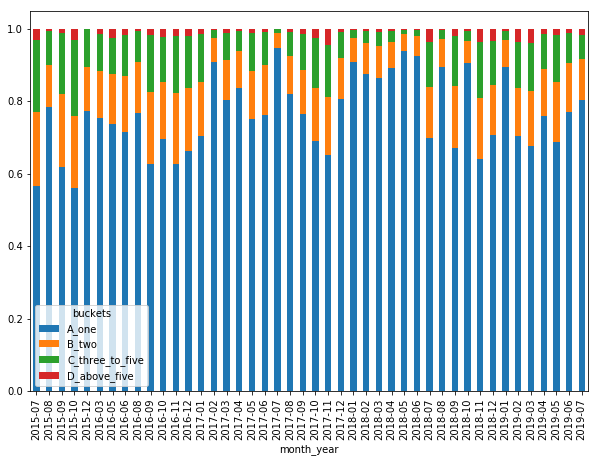

In [194]:
pivot_df = to_pivot_this.pivot(index='month_year', columns='buckets', values='share')
pivot_df.plot.bar(stacked=True, figsize=(10,7))